In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from groundingdino.util.inference import load_model, predict, annotate
import groundingdino.datasets.transforms as T
import torch
import transformers
import triton
import flash_attn
import time

In [2]:
print(torch.__version__)
print(transformers.__version__)
print(triton.__version__)
print(flash_attn.__version__)

2.3.1+cu121
4.49.0
2.3.1
2.5.9.post1


In [3]:
!ls groundingdino/config

GroundingDINO_SwinT_OGC.py


In [4]:


# Load model on GPU
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

model = load_model("groundingdino/config/GroundingDINO_SwinT_OGC.py", "groundingdino_weights/groundingdino_swint_ogc.pth")
model.to(DEVICE).eval()

Using device: cuda


final text_encoder_type: bert-base-uncased


GroundingDINO(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x DeformableTransformerEncoderLayer(
          (self_attn): MultiScaleDeformableAttention(
            (sampling_offsets): Linear(in_features=256, out_features=256, bias=True)
            (attention_weights): Linear(in_features=256, out_features=128, bias=True)
            (value_proj): Linear(in_features=256, out_features=256, bias=True)
            (output_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (dropout1): Dropout(p=0.0, inplace=False)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout2): Dropout(p=0.0, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (dropout3): Dropout(p=0.0, inplace=False)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_aff

In [5]:
model

GroundingDINO(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x DeformableTransformerEncoderLayer(
          (self_attn): MultiScaleDeformableAttention(
            (sampling_offsets): Linear(in_features=256, out_features=256, bias=True)
            (attention_weights): Linear(in_features=256, out_features=128, bias=True)
            (value_proj): Linear(in_features=256, out_features=256, bias=True)
            (output_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (dropout1): Dropout(p=0.0, inplace=False)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout2): Dropout(p=0.0, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (dropout3): Dropout(p=0.0, inplace=False)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_aff

In [19]:
def prepare_image(image_array: np.ndarray) -> torch.Tensor:
    transform = T.Compose(
        [
            # T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    image_transformed, _ = transform(image_array, None)
    return image_transformed

import torch

def nms_cxcywh(boxes, scores, iou_thresh=0.5):
    """
    boxes: (N,4) in (cx, cy, w, h) (either normalized or absolute)
    scores: (N,) confidence scores
    returns: List[int] of kept indices (in descending‐score order)
    """
    # 1) ensure tensors
    boxes  = torch.as_tensor(boxes, dtype=torch.float32)
    scores = torch.as_tensor(scores, dtype=torch.float32)

    # 2) corner coords
    x1 = boxes[:,0] - boxes[:,2]/2
    y1 = boxes[:,1] - boxes[:,3]/2
    x2 = boxes[:,0] + boxes[:,2]/2
    y2 = boxes[:,1] + boxes[:,3]/2

    # 3) sort scores descending
    order = scores.argsort(descending=True)
    keep  = []

    # 4) iterate
    while order.numel() > 0:
        i = order[0].item()
        keep.append(i)
        if order.numel() == 1:
            break

        # compute IoU of box i vs the rest
        xx1 = torch.max(x1[i], x1[order[1:]])
        yy1 = torch.max(y1[i], y1[order[1:]])
        xx2 = torch.min(x2[i], x2[order[1:]])
        yy2 = torch.min(y2[i], y2[order[1:]])

        inter = (xx2 - xx1).clamp(min=0) * (yy2 - yy1).clamp(min=0)
        area_i = (x2[i] - x1[i]) * (y2[i] - y1[i])
        areas  = (x2[order[1:]] - x1[order[1:]]) * (y2[order[1:]] - y1[order[1:]])
        union  = area_i + areas - inter
        iou    = inter / union

        # pick only those with IoU ≤ threshold
        inds = torch.where(iou <= iou_thresh)[0]
        if inds.numel() == 0:
            break

        # +1 because we skipped order[0]
        order = order[inds + 1]

    return keep


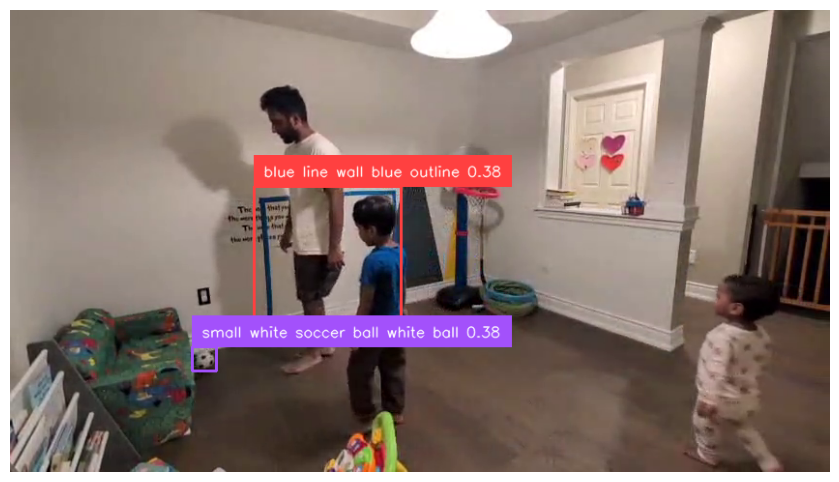

In [47]:
# Load video
cap = cv2.VideoCapture("../data/soccer_short_clip.mp4")  # Replace with 0 for webcam

# Show helper
def show_frame(img, figsize=(12, 6)):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=figsize)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

frame_idx = -1
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame_idx += 1
    if frame_idx < 150:
        continue
    # scale = 1.
    # resized_frame = cv2.resize(frame, None, fx=scale, fy=scale)
    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    height, width = image_rgb.shape[:2]

    caption = (
        "hidden ball . small white soccer ball . white ball . toy ball . moving ball . blurry ball . ball moving"
        " . blue line wall . blue outline"
    )
    
    # 2)  One single predict()
    boxes, logits, phrases = predict(
        model,
        prepare_image(image_rgb),
        caption,
        box_threshold=0.2,
        text_threshold=0.2
    )
    
    # 3)  Define your keyword sets
    ball_terms = {
        "hidden ball", "small white soccer ball", "white ball",
        "toy ball", "moving ball", "blurry ball", "ball moving"
    }
    wall_terms = {"blue line wall", "blue outline"}
    
    # 4)  Partition detections by which keyword they matched
    ball_idxs = [i for i,p in enumerate(phrases) if any(t in p for t in ball_terms)]
    wall_idxs = [i for i,p in enumerate(phrases) if any(t in p for t in wall_terms)]

    best_ball_idx = max(ball_idxs, key=lambda i: logits[i]) if ball_idxs else None
    best_wall_idx = max(wall_idxs, key=lambda i: logits[i]) if wall_idxs else None


    # 2) build the lists for annotate()
    best_boxes   = []
    best_logits  = []
    best_phrases = []
    
    if best_ball_idx is not None and logits[best_ball_idx] > 0.31:
        best_boxes  .append(boxes[best_ball_idx])
        best_logits .append(logits[best_ball_idx])
        best_phrases.append(phrases[best_ball_idx])
    
    if best_wall_idx is not None and logits[best_wall_idx] > 0.35:
        best_boxes  .append(boxes[best_wall_idx])
        best_logits .append(logits[best_wall_idx])
        best_phrases.append(phrases[best_wall_idx])

    if len(best_boxes) == 0:
        best_boxes = torch.empty((0, 4), dtype=torch.float32)
    else:
        best_boxes = torch.stack(best_boxes)

    annotated_frame = annotate(image_source=image_rgb, boxes=best_boxes, logits=best_logits, phrases=best_phrases)

    # Display frame
    clear_output(wait=True)
    show_frame(annotated_frame)
    # time.sleep(0.3)

In [41]:
ball_idxs

[1, 2, 7, 8, 9]

In [42]:
wall_idxs

[0, 3, 6, 10]

In [43]:
best_ball_idx

1

In [44]:
best_boxes

tensor([[0.2900, 0.7126, 0.0292, 0.0512],
        [0.3644, 0.5228, 0.1309, 0.2901]])